# Memory Retrieval Inductive Biases [`dev`]


- make memory retrieval symmetric


$$
\begin{align*}
x^{(t)} &= (x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
x &= (x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\begin{align*}
E^{(t)} &\gets \mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_{l_m}^{(t)})\\
E &\gets \mathrm{CausalSelfAttn}(x_1, \ldots, x_{l_x})
\end{align*}
$$

$$
\mathrm{HierAttn}(Q \gets E_i, K \gets E^{(t)}, V \gets E^{(t)} / y^{(t)})
$$

$$K(x_i, x^{(t)}) = \phi_q(\mathrm{CausalSelfAttn}(x_1, \ldots, x_i))^\top \phi_k(\mathrm{CausalSelfAttn}(x_1^{(t)}, \ldots, x_j^{(t)}))$$


$l_x \times l_m \times n_m \times n_h$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from tqdm.keras import TqdmCallback

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers

/Users/ruixiaowang/opt/anaconda3/envs/IML_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-07 16:08:08.301970: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Generate Data

In [3]:
num_loops = 4
loop_length = 6 # for now, fixed length
num_notes = 6 # size of observation space

state_transition_edges = []

for l in range(num_loops):
    for s in range(loop_length):
        state_transition_edges.append((f's{l}{s}', f's{l}{(s+1)%loop_length}'))

    # NOTE: this adds connections between loops
    # for l2 in range(num_loops):
    #     state_transition_edges.append((f's{l}0', f's{l2}0'))

In [4]:
graph = nx.DiGraph(state_transition_edges)
states = list(graph.nodes())
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

emissions = [f'o{i}' for i in range(num_notes)]
idx_to_emission = {i: o for i,o in enumerate(emissions)}
emission_to_idx = {o: i for i,o in enumerate(emissions)}

In [5]:
state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())
state_transition_matrix = state_transition_matrix / np.sum(state_transition_matrix, axis=0)[:, np.newaxis]

/var/folders/86/rz4f689d2sb1ld1x196j98zm0000gn/T/ipykernel_200/216198539.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  state_transition_matrix = np.array(nx.adjacency_matrix(graph, nodelist=state_to_idx.keys()).todense())


In [6]:
emissions_dict = {s: idx_to_emission[np.random.randint(num_notes)] for s in states}
emissions_dict

{'s00': 'o3',
 's01': 'o3',
 's02': 'o5',
 's03': 'o3',
 's04': 'o5',
 's05': 'o0',
 's10': 'o5',
 's11': 'o3',
 's12': 'o2',
 's13': 'o1',
 's14': 'o0',
 's15': 'o5',
 's20': 'o4',
 's21': 'o4',
 's22': 'o2',
 's23': 'o3',
 's24': 'o2',
 's25': 'o1',
 's30': 'o1',
 's31': 'o3',
 's32': 'o1',
 's33': 'o4',
 's34': 'o5',
 's35': 'o0'}

In [7]:
emissions_matrix = np.zeros((len(states), num_notes))
for i, s in enumerate(states):
    emissions_matrix[i, emission_to_idx[emissions_dict[s]]] = 1

In [11]:
def sample_hmm(transition_matrix, emissions_matrix, initial_state, num_steps):
    current_state = initial_state
    states_seq = [current_state]
    emissions_seq = [np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :])]

    for i in range(num_steps-1):
        probabilities = transition_matrix[state_to_idx[current_state], :]
        next_state = np.random.choice(states, p=probabilities)
        states_seq.append(next_state)
        current_state = next_state
        emissions_seq.append(np.random.choice(emissions, p=emissions_matrix[state_to_idx[current_state], :]))
    return states_seq, emissions_seq

In [12]:
mem_seq_len = loop_length + 1
input_seq_len = 2*loop_length

mem_seq_initial_states = [f's{l}0' for l in range(num_loops)]
input_seqs_initial_states = [f's{l}0' for l in range(num_loops)]

train_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
train_state_seqs, train_emissions_seqs = train_seqs[:, 0, :], train_seqs[:, 1, :]
train_seqs_x = train_emissions_seqs[:, :-1]
train_seqs_y = train_emissions_seqs[:, 1:]

test_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, input_seq_len+1) for initial_state in input_seqs_initial_states])
test_state_seqs, test_emissions_seqs = test_seqs[:, 0, :], test_seqs[:, 1, :]
test_seqs_x = test_emissions_seqs[:, :-1]
test_seqs_y = test_emissions_seqs[:, 1:]


mem_seqs = np.array([sample_hmm(state_transition_matrix, emissions_matrix, initial_state, mem_seq_len + 1) for initial_state in mem_seq_initial_states])
mem_seqs = np.repeat(np.expand_dims(mem_seqs, axis=0), axis=0, repeats=len(train_seqs))
mem_state_seqs, mem_emissions_seqs = mem_seqs[:, :, 0, :], mem_seqs[:, :, 1, :]
mem_seqs_x = mem_emissions_seqs[:, :, :-1]
mem_seqs_y = mem_emissions_seqs[:, :, 1:]

In [13]:
print(f'train_seqs_x.shape: {train_seqs_x.shape}; train_seqs_y.shape: {train_seqs_y.shape}') # shape [batch_size, seq_len]
print(f'mem_seqs_x.shape: {mem_seqs_x.shape}; mem_seqs_y.shape: {mem_seqs_y.shape}') # shape [batch_size, num_mem_seqs, mem_seq_len]

train_seqs_x.shape: (4, 12); train_seqs_y.shape: (4, 12)
mem_seqs_x.shape: (4, 4, 7); mem_seqs_y.shape: (4, 4, 7)


In [14]:
maptoidx = np.vectorize(lambda x: emission_to_idx[x])
train_seqs_x = maptoidx(train_seqs_x)
train_seqs_y = maptoidx(train_seqs_y)
test_seqs_x = maptoidx(test_seqs_x)
test_seqs_y = maptoidx(test_seqs_y)
mem_seqs_x = maptoidx(mem_seqs_x)
mem_seqs_y = maptoidx(mem_seqs_y)

In [15]:
train_seqs_x
test_seqs_x
mem_seqs_x


array([[[3, 3, 5, 3, 5, 0, 3],
        [5, 3, 2, 1, 0, 5, 5],
        [4, 4, 2, 3, 2, 1, 4],
        [1, 3, 1, 4, 5, 0, 1]],

       [[3, 3, 5, 3, 5, 0, 3],
        [5, 3, 2, 1, 0, 5, 5],
        [4, 4, 2, 3, 2, 1, 4],
        [1, 3, 1, 4, 5, 0, 1]],

       [[3, 3, 5, 3, 5, 0, 3],
        [5, 3, 2, 1, 0, 5, 5],
        [4, 4, 2, 3, 2, 1, 4],
        [1, 3, 1, 4, 5, 0, 1]],

       [[3, 3, 5, 3, 5, 0, 3],
        [5, 3, 2, 1, 0, 5, 5],
        [4, 4, 2, 3, 2, 1, 4],
        [1, 3, 1, 4, 5, 0, 1]]])

# Kernel Model (Symmetric)

In [63]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)

        self.symmetric_attention = symmetric_attention
        self.alpha_it = None
        self.embedder = layers.Embedding(vocab_size, embedding_dim, name='embedder')
        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''

        def get_memory_cross_probs(Et):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        cross_probs = tf.map_fn(get_memory_cross_probs, tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3]))
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components coresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed

    def compute_mem_attention_scores(self, cross_probs_observed):
        '''compute memory-level attention scores, alpha_it (i is position in input sequence, t is memory index)'''

        log_cross_probs_observed = tf.math.log(cross_probs_observed)
        w_it = tf.math.cumsum(log_cross_probs_observed, axis=-1, exclusive=True)
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it

    def call(self, inputs):
        seq_input, memory_input = inputs

        # embed input sequences and memory sequences
        embedded_input_seqs = self.embedder(seq_input)
        embedded_mem_x_seqs = self.embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)

        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs), axis=1)

        return output

In [64]:
train_ds = tf.data.Dataset.from_tensor_slices(((train_seqs_x, mem_seqs_x), train_seqs_y)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices(((test_seqs_x, mem_seqs_x), test_seqs_y)).batch(4)

vocab_size = num_notes 
embedding_dim = num_notes // 3


kernel_model = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim // 2, n_heads=2, ff_sizes = [embedding_dim,], symmetric_attention=True, name='kernel_memory_model')

kernel_model([train_seqs_x, mem_seqs_x]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_16 (C  multiple                 22        
 ausalSelfAttention)                                             
                                                                 
 cross_attention_14 (CrossAt  multiple                 16        
 tention)                                      

In [65]:
fit_kwargs = dict(epochs=30)

from tqdm.keras import TqdmCallback
from tqdm import tqdm
def create_callbacks():
    return [TqdmCallback(tqdm_class=tqdm)]

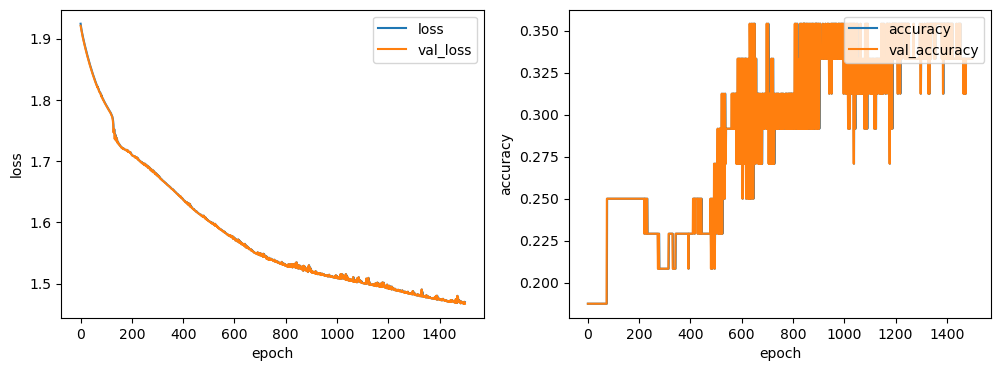

In [66]:
history1 = kernel_model.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=1500)
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

In [72]:

embedding_dim = num_notes


kernel_model = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim, n_heads=1, ff_sizes = [embedding_dim,], symmetric_attention=True, name='kernel_memory_model')

kernel_model([train_seqs_x, mem_seqs_x]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  36        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_20 (C  multiple                 138       
 ausalSelfAttention)                                             
                                                                 
 cross_attention_18 (CrossAt  multiple                 96        
 tention)                                      

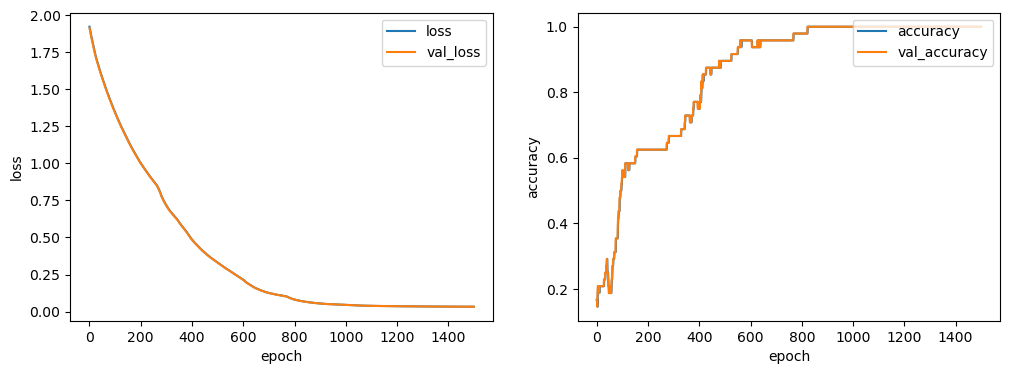

In [73]:
history1 = kernel_model.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=1500)
utils.plot_history(history1, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

1/1 [==============================] - 0s 11ms/step - loss: 0.0324 - accuracy: 1.0000


1/1 [==============================] - 0s 457ms/step


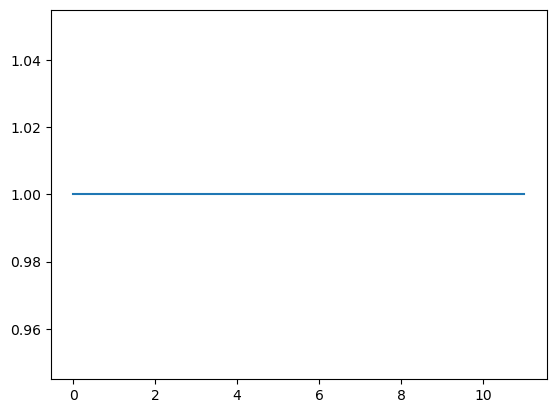

In [74]:
kernel_model.evaluate(train_ds)
kernel_model.evaluate(test_ds)
# plot accuracy as a function of position in sequence
preds = kernel_model.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == test_seqs_y, axis=0)
plt.plot(acc_by_pos)

sample_input:  [[3 3 5 3 5 0 3 3 5 3 5 0]]
prediction: [3 5 3 5 0 3 3 5 3 5 0 3]
y: [3 5 3 5 0 3 3 5 3 5 0 3]
[ True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[5 3 2 1 0 5 5 3 2 1 0 5]]
prediction: [3 2 1 0 5 5 3 2 1 0 5 5]
y: [3 2 1 0 5 5 3 2 1 0 5 5]
[ True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[4 4 2 3 2 1 4 4 2 3 2 1]]
prediction: [4 2 3 2 1 4 4 2 3 2 1 4]
y: [4 2 3 2 1 4 4 2 3 2 1 4]
[ True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[1 3 1 4 5 0 1 3 1 4 5 0]]
prediction: [3 1 4 5 0 1 3 1 4 5 0 1]
y: [3 1 4 5 0 1 3 1 4 5 0 1]
[ True  True  True  True  True  True  True  True  True  True  True  True]


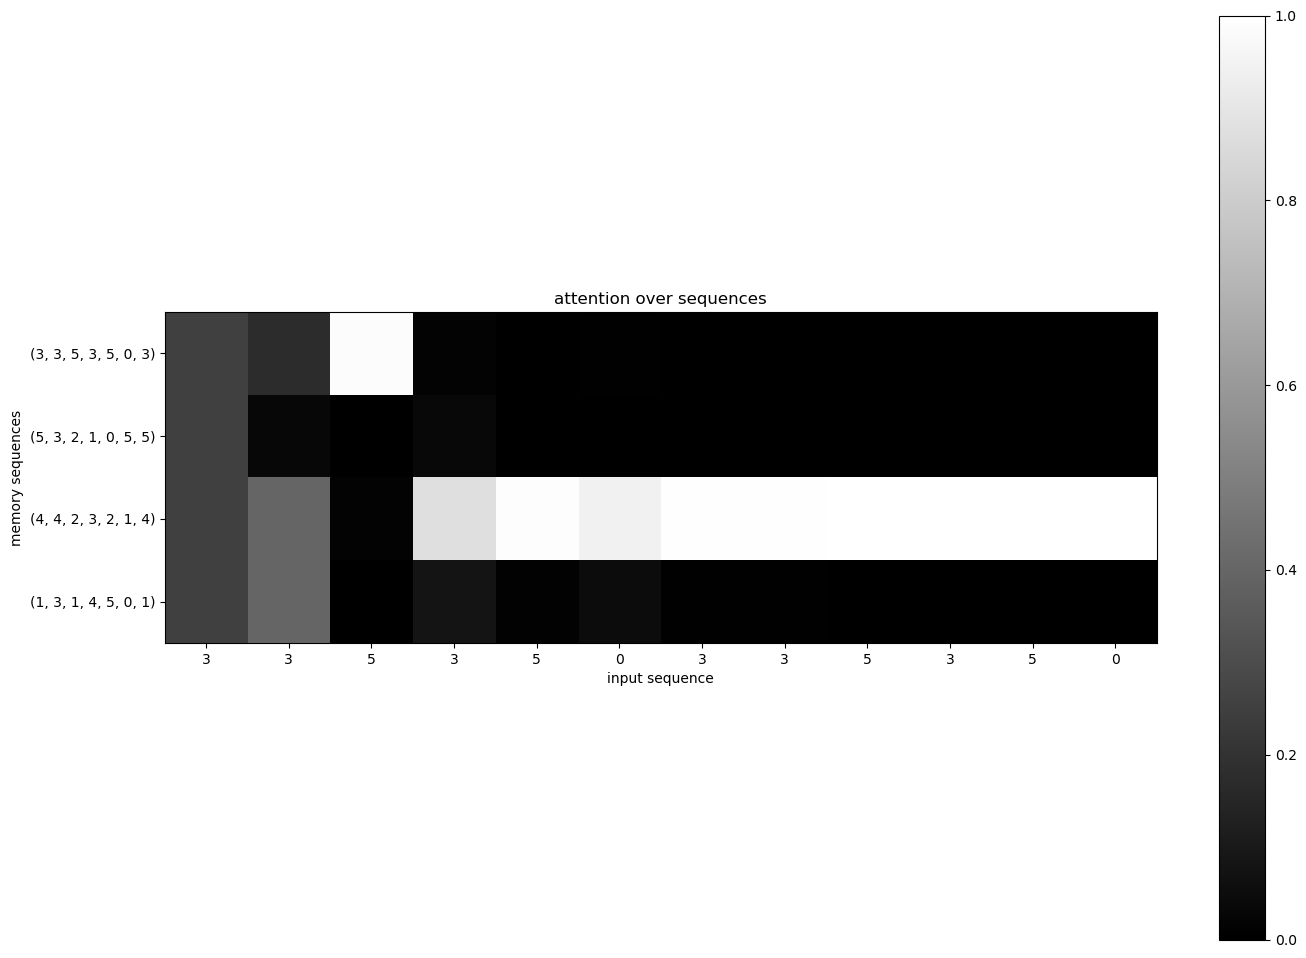

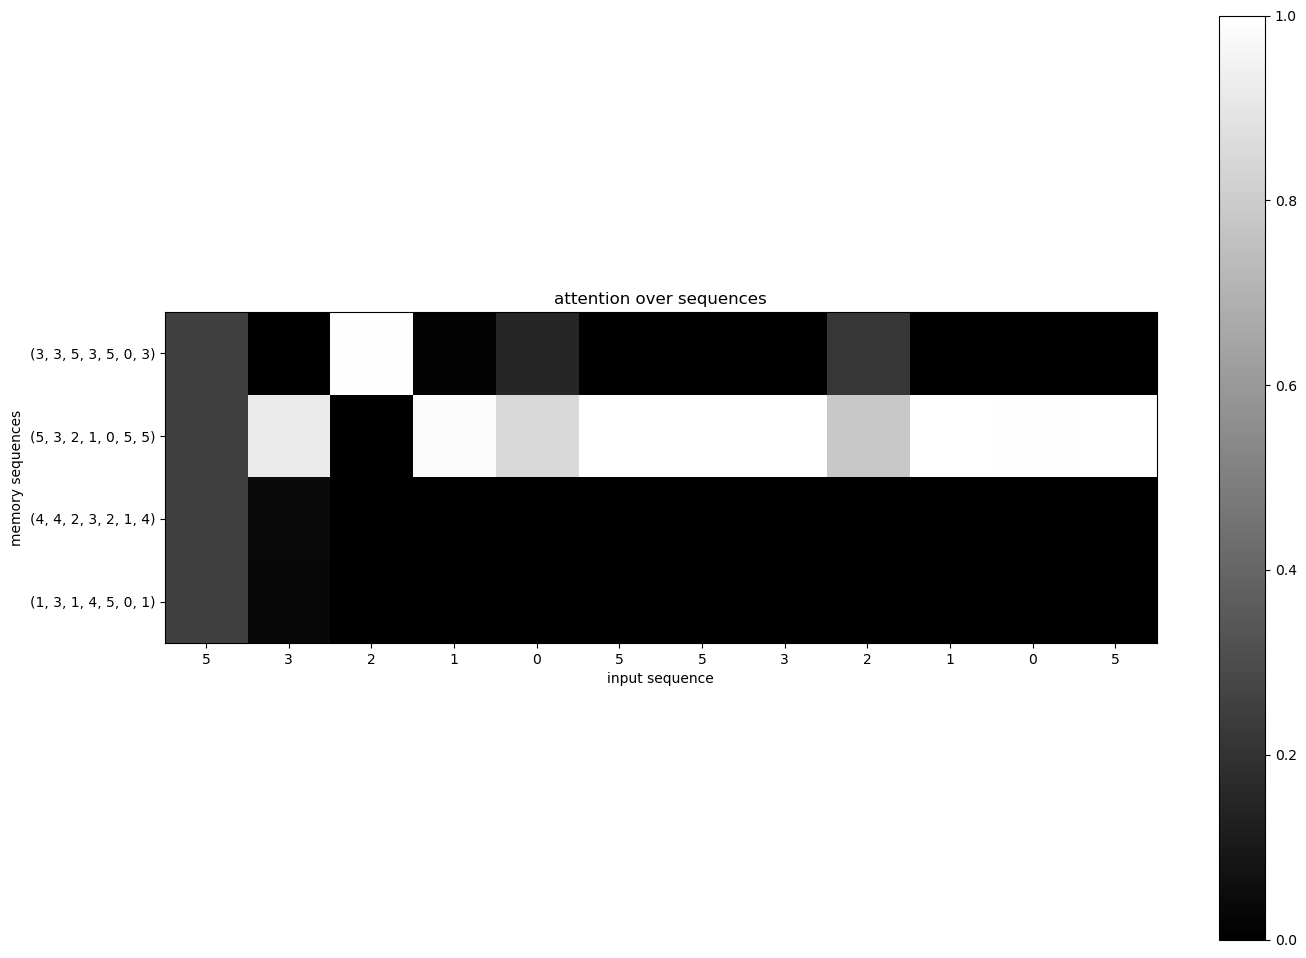

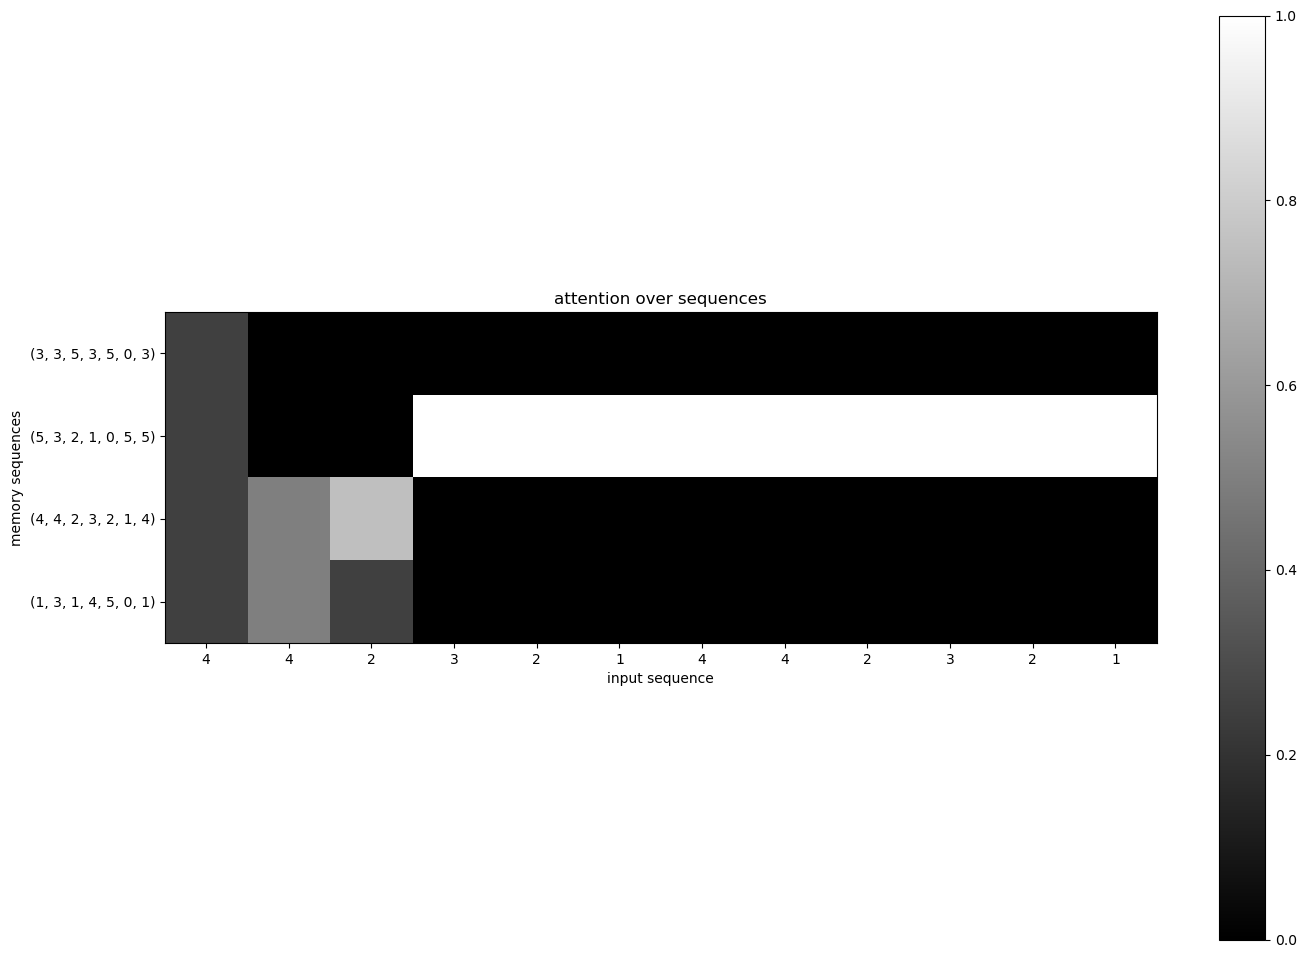

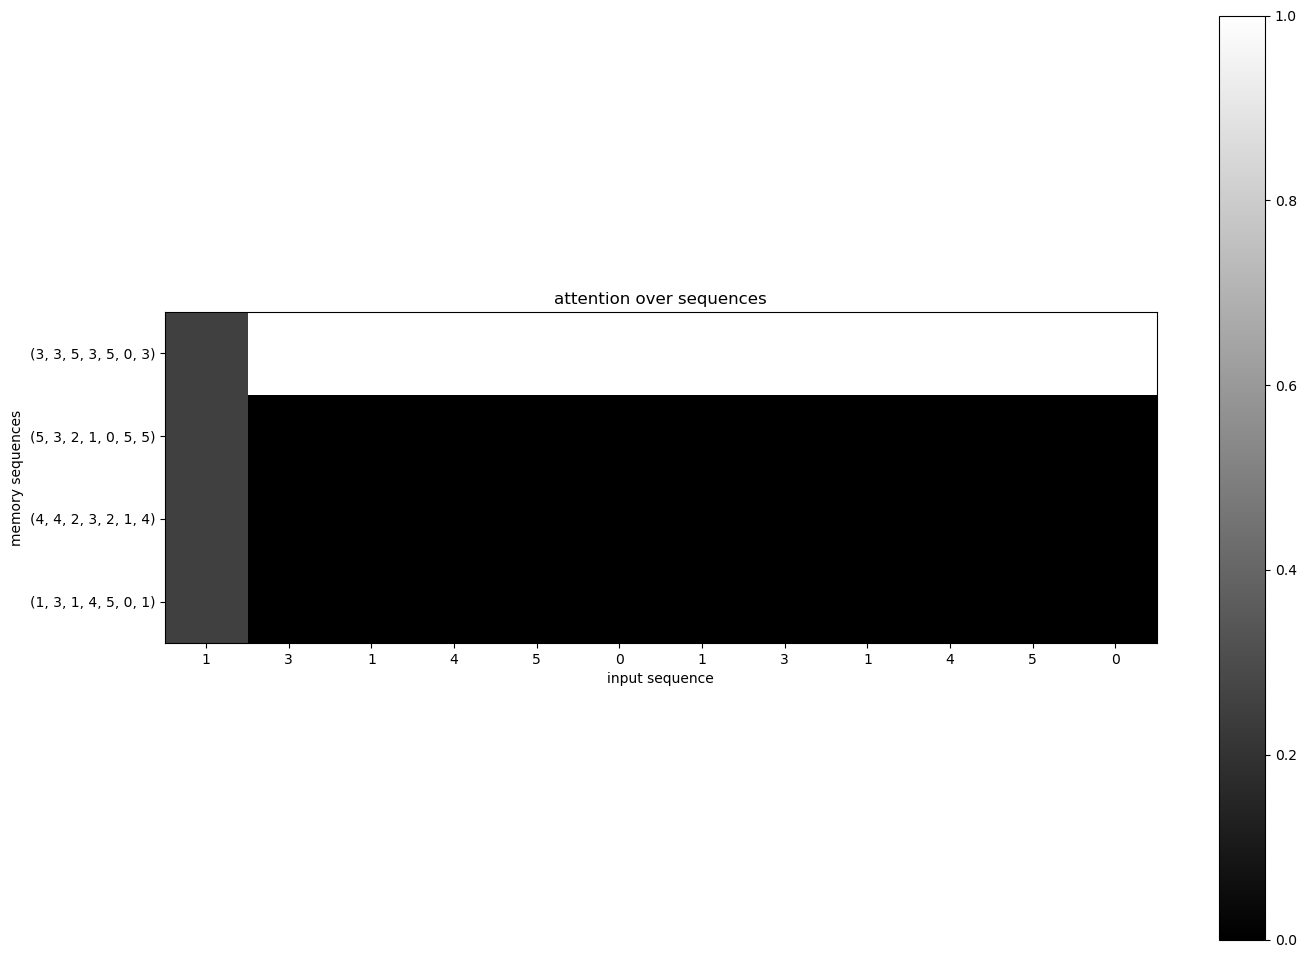

In [76]:
from utils_kernel_transformer import plot_attention 



for idx in range(4):
    plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, kernel_model)

## Kernel Model (non-symmetric)

In [77]:

vocab_size = num_notes 
embedding_dim = num_notes // 3
kernel_model2 = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim // 2, n_heads=2, ff_sizes = [embedding_dim,], name='kernel_memory_model2')

kernel_model2([train_seqs_x, mem_seqs_x]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model2.summary()

Model: "kernel_memory_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  12        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_21 (C  multiple                 22        
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_9 (Gl  multiple                 22        
 obalSelfAttention)                           

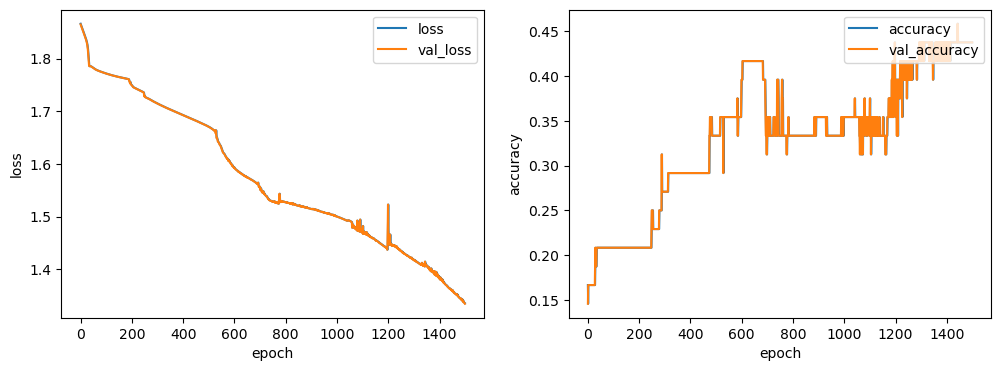

In [78]:
history2 = kernel_model2.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=1500)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

In [80]:
embedding_dim = num_notes


kernel_model2 = KernelMemoryTransformer(
    vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim, n_heads=1, ff_sizes = [embedding_dim,], symmetric_attention=False, name='kernel_memory_model')

kernel_model2([train_seqs_x, mem_seqs_x]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model2.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model2.summary()

Model: "kernel_memory_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedder (Embedding)        multiple                  36        
                                                                 
 pos_embedder_adder (AddPosi  multiple                 0         
 tionalEmbedding)                                                
                                                                 
 mem_pos_embedder_adder (Mem  multiple                 0         
 oryAddPositionalEmbedding)                                      
                                                                 
 causal_self_attention_23 (C  multiple                 138       
 ausalSelfAttention)                                             
                                                                 
 global_self_attention_10 (G  multiple                 138       
 lobalSelfAttention)                           


























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































2023-09-07 16:47:29.478350: W tensorflow/core/d

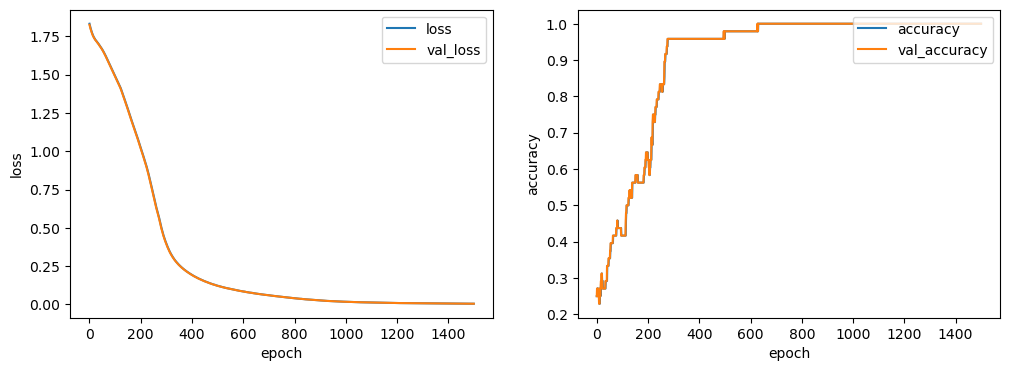

In [81]:
history2 = kernel_model2.fit(train_ds, validation_data=test_ds, verbose=0, callbacks=create_callbacks(), epochs=1500)
utils.plot_history(history2, plot_attrs=('loss', 'accuracy'), val=True, figsize=(12,4));

1/1 [==============================] - 0s 440ms/step


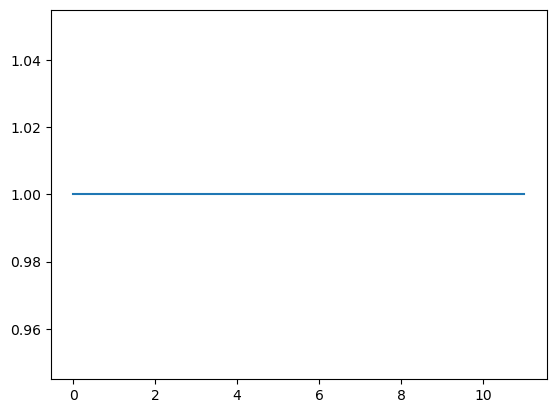

In [82]:
kernel_model2.evaluate(train_ds)
kernel_model2.evaluate(test_ds)
# plot accuracy as a function of position in sequence
preds = kernel_model2.predict(test_ds)
preds = np.argmax(preds, axis=-1)
acc_by_pos = np.mean(preds == test_seqs_y, axis=0)
plt.plot(acc_by_pos)

sample_input:  [[3 3 5 3 5 0 3 3 5 3 5 0]]
prediction: [3 5 3 5 0 3 3 5 3 5 0 3]
y: [3 5 3 5 0 3 3 5 3 5 0 3]
[ True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[5 3 2 1 0 5 5 3 2 1 0 5]]
prediction: [3 2 1 0 5 5 3 2 1 0 5 5]
y: [3 2 1 0 5 5 3 2 1 0 5 5]
[ True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[4 4 2 3 2 1 4 4 2 3 2 1]]
prediction: [4 2 3 2 1 4 4 2 3 2 1 4]
y: [4 2 3 2 1 4 4 2 3 2 1 4]
[ True  True  True  True  True  True  True  True  True  True  True  True]
sample_input:  [[1 3 1 4 5 0 1 3 1 4 5 0]]
prediction: [3 1 4 5 0 1 3 1 4 5 0 1]
y: [3 1 4 5 0 1 3 1 4 5 0 1]
[ True  True  True  True  True  True  True  True  True  True  True  True]


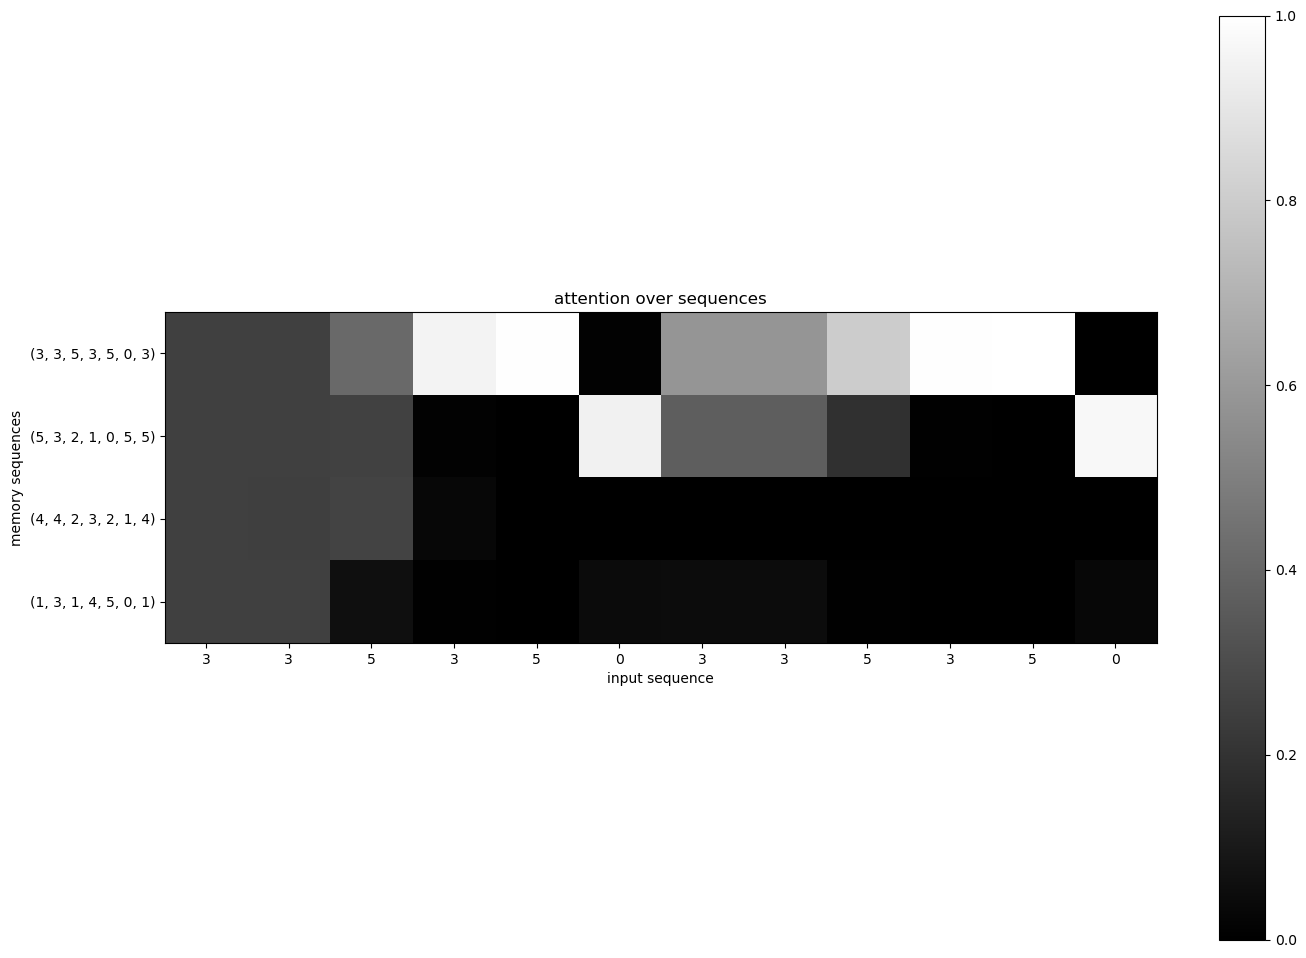

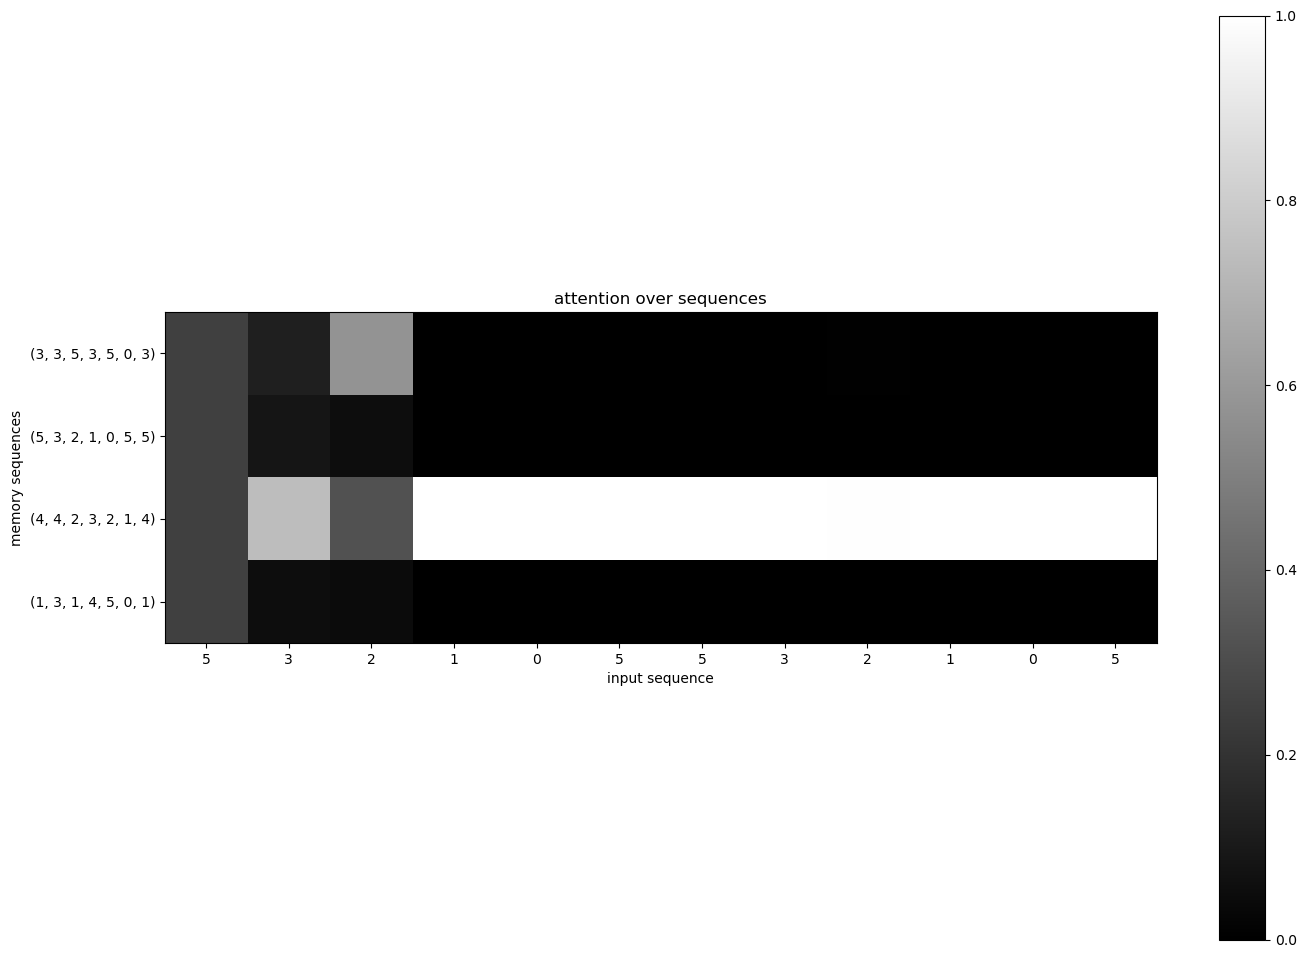

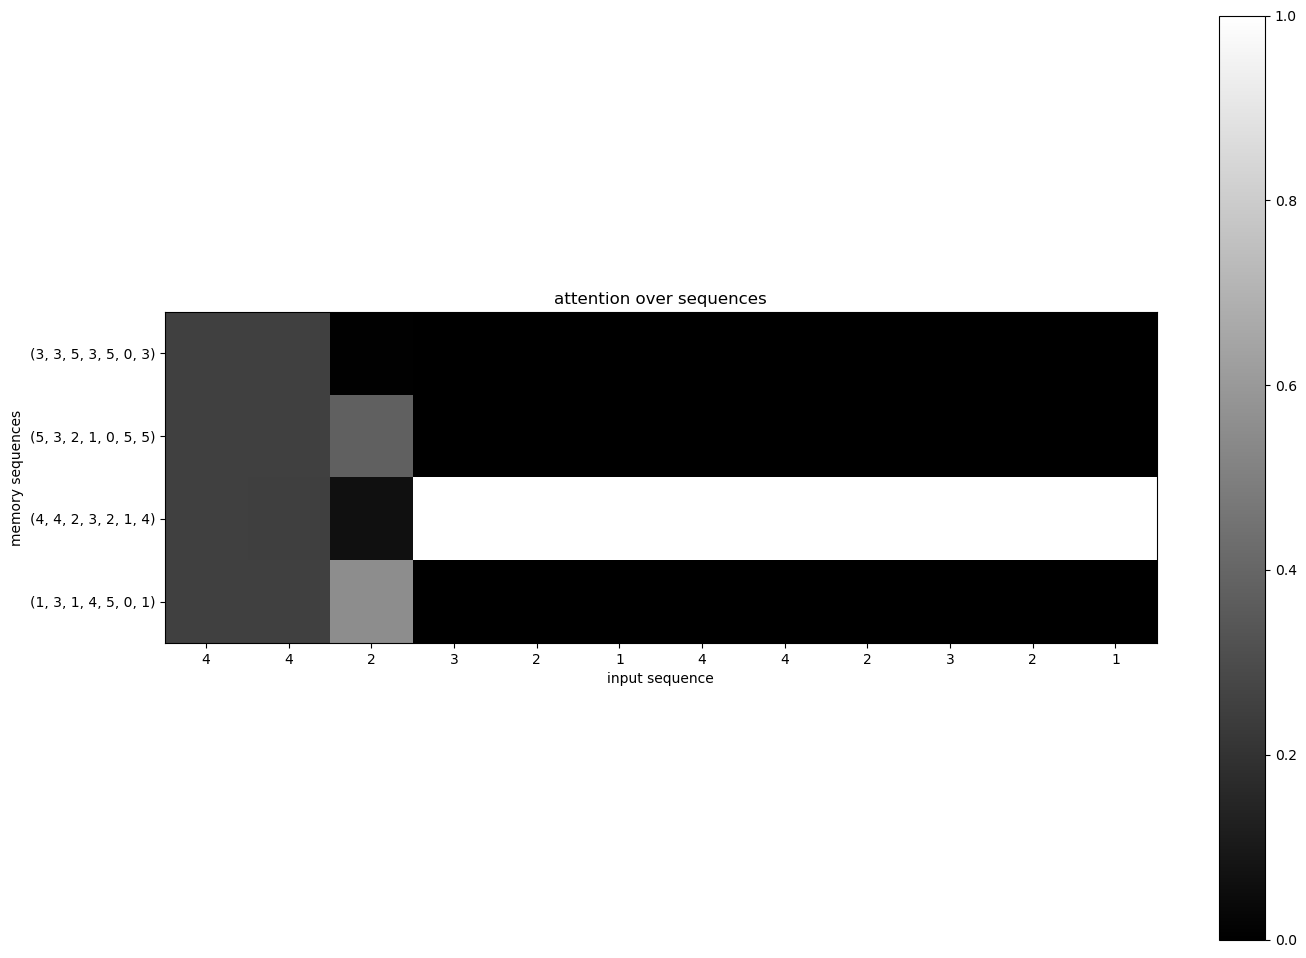

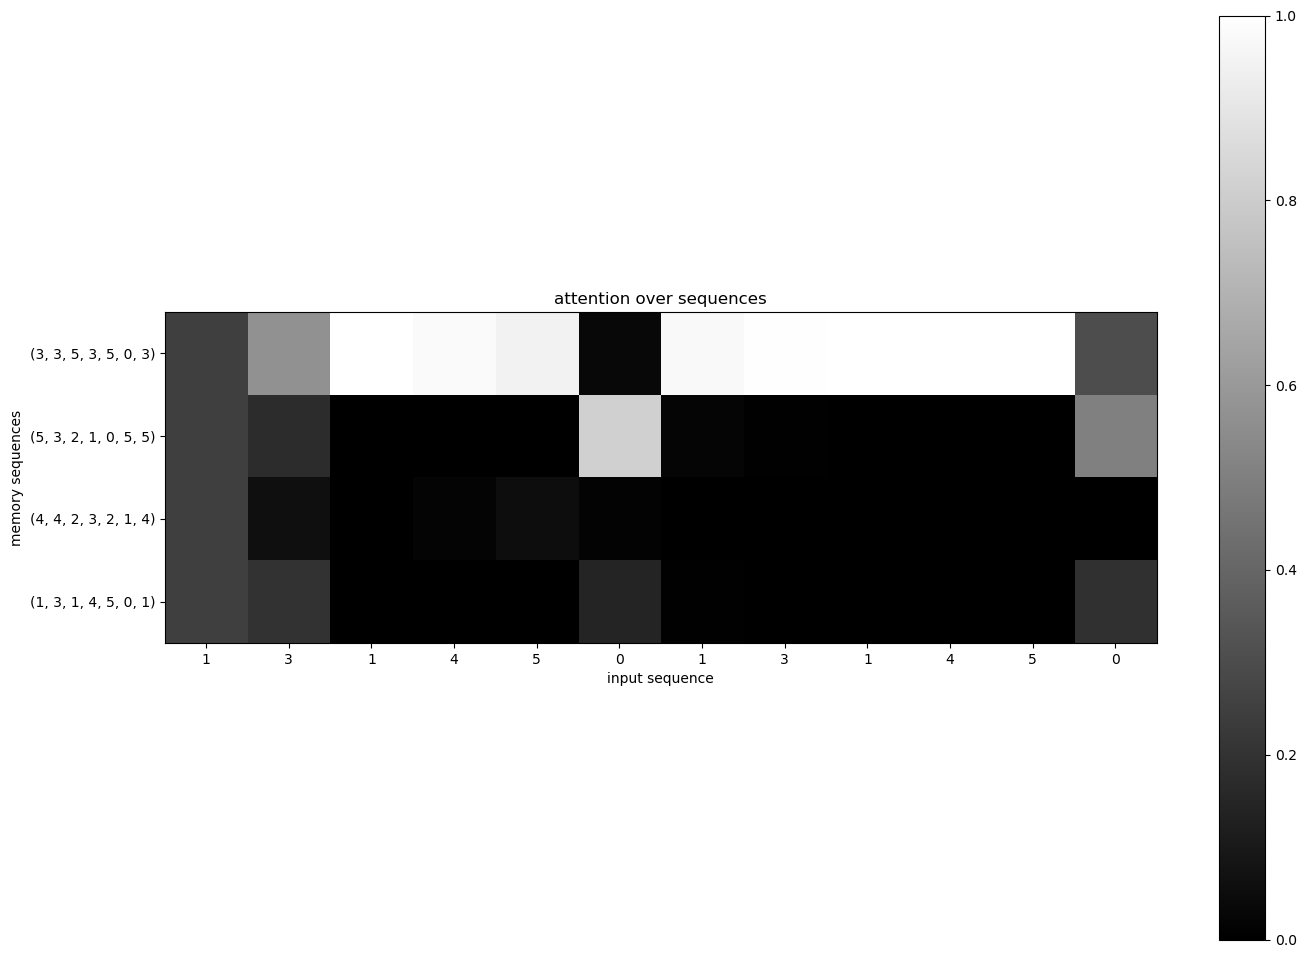

In [84]:

for idx in range(4):
    plot_attention(idx, train_seqs_x, train_seqs_y, mem_seqs_x, mem_seqs_y, kernel_model2)